In [15]:
% reset -f

from os import listdir


from PIL import Image


# to compute time of pipeline
from time import time, strftime, gmtime


from sklearn.metrics import confusion_matrix, classification_report

from preprocess_images import *
from sift_functions import *

% matplotlib inline
% autosave 300

Autosaving every 300 seconds


In [17]:
# Starting time
t0 = time()

input_path = "./dataset/cleaned/"
path_images = "./dataset/images/"
input_filename = "data_images.csv"
input_file = "{}{}".format(input_path, input_filename)

output_path = "./dataset/cleaned/"

In [18]:
list_photos = [file for file in listdir(path_images)]
print(len(list_photos))

1050


In [19]:
data_images = pd.read_csv(input_file)
data_images.head()

,image_path,category,target
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


# PART 1 : SIFT

Description du webinaire (compétences abordées) : L’objectif est d’acquérir
la compétence de prétraitement d’images via SIFT ou ORB, afin de créer des
“features” pour chacune des images sous forme de “bag of visual words”, puis
d’analyser ces features d’images, en particulier la capacité à séparer
naturellement les images selon les catégories réelles via une réduction de
dimension T-SNE et un affichage en 2D.


## Création des labels des photos à partir du nom des images

In [20]:
print("TEST")
#img = Image.open(path_images + "0906fd9cc604fbba05a502e01d763cd9.jpg")

# Afficher l'image chargée
#img.show()

TEST


In [21]:
list_labels = data_images["category"].unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [22]:
#data_images["image_path"] = list_photos

In [23]:
display(data_images.groupby("target").count())
print("The data is balanced !")

,image_path,category
target,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


The data is balanced !


## Affichage d'exemples d'images par label

Home Furnishing
-------
For this category, we have 150 images.


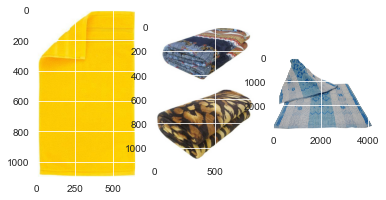

Baby Care
-------
For this category, we have 150 images.


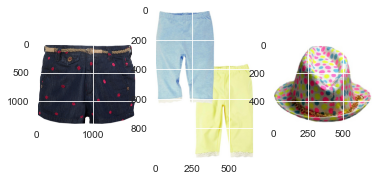

Watches
-------
For this category, we have 150 images.


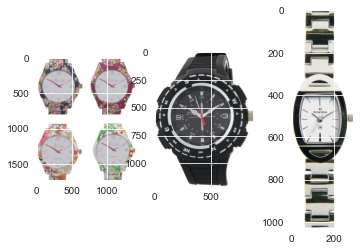

Home Decor & Festive Needs
-------
For this category, we have 150 images.


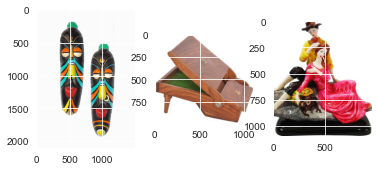

Kitchen & Dining
-------
For this category, we have 150 images.


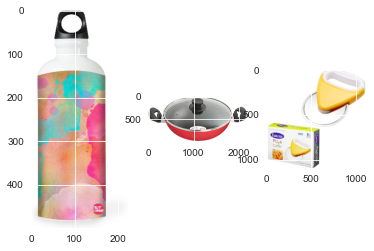

Beauty and Personal Care
-------
For this category, we have 150 images.


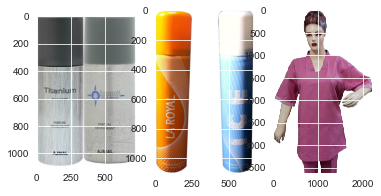

Computers
-------
For this category, we have 150 images.


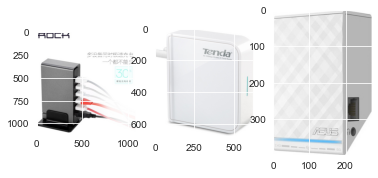

In [24]:
n_categories = len(list_labels)
n_photos = len(list_photos)

display_images_per_category(list_labels, data_images, path_images, "image_path", "category", list_photos)

## Détermination et affichage des descripteurs SIFT

* L'image contient 319 descripteurs
* Chaque descripteur est un vecteur de longueur 128

In [25]:
filename = path_images + list_photos[0]
img = Image.open(filename)

# Afficher l'image chargée
img.show()

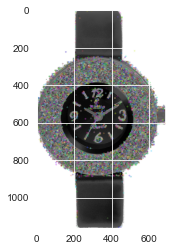

Descripteurs :  (4150, 128)

[[  3.  52. 133. ...   4.  30.  22.]
 [ 11.   1.   4. ...   0.   0.   0.]
 [  0.   0.   1. ...  14.   2.   4.]
 ...
 [ 14.   3.   5. ...   0.   0.   0.]
 [ 34.  18.   9. ...   0.   2.   3.]
 [  9. 128.  45. ...   0.   0.   0.]]


In [26]:
sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path_images + list_photos[0], 0)  # convert in gray
image = cv2.equalizeHist(image)  # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img = cv2.drawKeypoints(image, kp, image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


In [27]:
data_images

,image_path,category,target
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


# Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

sift_keypoints_by_img, sift_keypoints_all = generate_keypoints(data_images, "image_path", path_images)
save_features("dataset/", "keypoints_by_img.npz", sift_keypoints_by_img)
save_features("dataset/", "keypoints_all.npz", sift_keypoints_all)

In [70]:
sift_keypoints_all = load_features("dataset/", "keypoints_all.npz")
sift_keypoints_all

NameError: name 'load_features' is not defined

In [30]:
sift_keypoints_by_img = load_features("dataset/", "keypoints_by_img.npz")
sift_keypoints_by_img

## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [66]:
kmeans = get_bag_of_images(sift_keypoints_all)

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :            11.95 secondes


## Création des features des images
* Pour chaque image :
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

In [76]:
im_features = get_images_features(sift_keypoints_by_img, kmeans)

100%|██████████| 1050/1050 [00:03<00:00, 322.31it/s]

temps de création histogrammes :             3.26 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [77]:
im_features

array([[0.   , 0.   , 0.002, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.006, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.002, 0.   , 0.004],
       ...,
       [0.   , 0.008, 0.002, ..., 0.002, 0.   , 0.008],
       [0.   , 0.   , 0.   , ..., 0.01 , 0.   , 0.   ],
       [0.   , 0.   , 0.002, ..., 0.   , 0.   , 0.   ]])

In [79]:
feat_pca = get_pca_for_features(im_features)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA avec 99% variance expliquée:  (1050, 498)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [56]:
X_tsne, df_tsne = get_tsne(feat_pca, data_images, "category")

(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images
* Les catégories "cloudy" et "rain" sont partiellement séparées

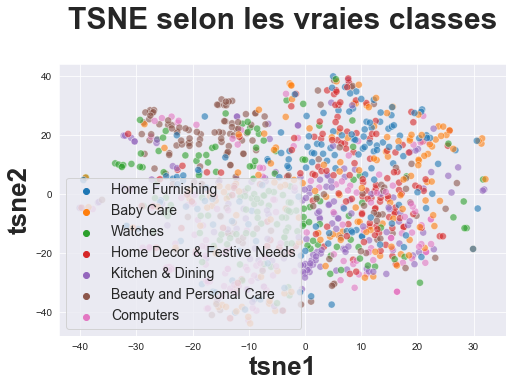

In [57]:
display_tsne(df_tsne, "class")

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [58]:
cls = clustering_tsne(X_tsne)
df_tsne = add_cluster_tsne(df_tsne, X_tsne)


(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de reste faible

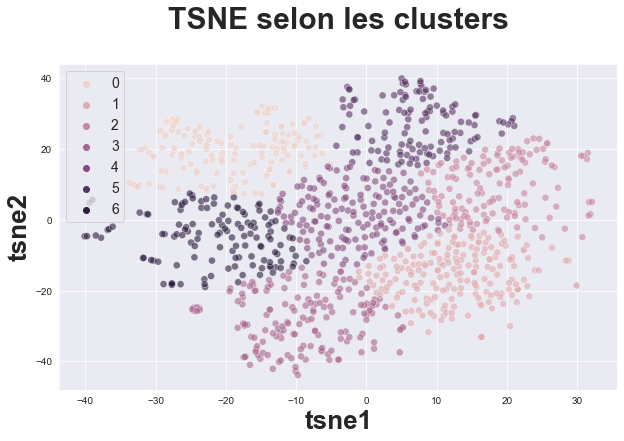

ARI :  0.06210462078739355


In [59]:
display_tsne(df_tsne, "cluster")
print_ari_score(data_images["target"], cls)

### Analyse par classes
* La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
* Cette transformation atteint ses limites pour les 2 catégories "shine" et "sunshine" qui sont peu séparées (donc elle a été réalisée manuellement au lieu d'utiliser la fonction "argmax")

In [60]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    149
1    198
2    132
3    157
4    164
5    120
6    130
Name: class, dtype: int64

In [61]:
conf_mat = confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 6 31 37 18 20 21 17]
 [78 16 10 13  9  7 17]
 [10 39  9 49 16  5 22]
 [ 6 35 31 10 20 35 13]
 [ 5 18 25 20 20 40 22]
 [13 38 15 31 31  6 16]
 [31 21  5 16 48  6 23]]


In [81]:
def conf_mat_transform(y_true, y_pred):
    conf_mat = confusion_matrix(y_true, y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print(corresp)
    corresp = [1, 5, 0, 2, 6, 4, 3]  # [1, 2, 0, 2, 6, 4, 6]
    print("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']

labels = data_images["target"]
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(classification_report(labels, cls_labels_transform))

[1 2 0 2 6 4 6]
Correspondance des clusters :  [1, 5, 0, 2, 6, 4, 3]
[[37  6 18 17 21 31 20]
 [10 78 13 17  7 16  9]
 [ 9 10 49 22  5 39 16]
 [31  6 10 13 35 35 20]
 [25  5 20 22 40 18 20]
 [15 13 31 16  6 38 31]
 [ 5 31 16 23  6 21 48]]

              precision    recall  f1-score   support

           0       0.28      0.25      0.26       150
           1       0.52      0.52      0.52       150
           2       0.31      0.33      0.32       150
           3       0.10      0.09      0.09       150
           4       0.33      0.27      0.30       150
           5       0.19      0.25      0.22       150
           6       0.29      0.32      0.31       150

    accuracy                           0.29      1050
   macro avg       0.29      0.29      0.29      1050
weighted avg       0.29      0.29      0.29      1050



<AxesSubplot:>

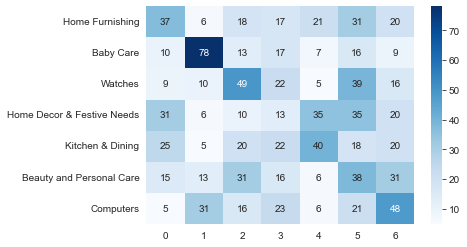

In [63]:
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[i for i in "0123456"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [44]:
# End of notebook time
t1 = time()
print("computing time : {:8.6f} sec".format(t1 - t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1 - t0)))

computing time : 592.443139 sec
computing time : 00:09:52
